**Note**: This notebook should take around **a minute** to run.

For a more comprehensive and detailed treatment of this problem, please refer to the [GitHub repository](https://github.com/HighDimensionalEconLab/transversality).

# The Economic Problem:

Consider the following problem:

$\begin{align}
\quad & \max_{\{c_t\}_{t=0}^\infty } \sum \beta^t u(c_t)\\
\quad & \text{s.t.}\quad  k_{t+1} = f(k_t) + (1-\delta) k_t -c_t\\
\quad & k_{t+1} \geq 0\\
\quad & k_0 \quad \text{is given},
\end{align}$

where $u(\cdot)$ is the utility function, $f(\cdot)$ is the prduction function, $\beta$ is the discount factor, and $k_0$ is the initial condition for capital.

#### First Order Condition

The Euler equation can be written as:

$\begin{align}
\quad & u'(c_t) = \beta u'(c_{t+1})\big[f'(k_{t+1})+(1-\delta)\big]
\end{align}$

To pin down the optimal solution a transversality condition is required, described as:

$\begin{align}
\quad & \lim_{T\rightarrow \infty} u'(c_T)k_{T+1} = 0
\end{align}$

#### The System of Equations Describing the Optimal Solution:

The optimal solution can be written as a **root** of the following system of equations:

$\begin{align}
\quad & \beta u'\big(c(t+1)\big)\bigg[f'\big(k(t+1)\big)+(1-\delta)\bigg] - u'\big(c(t)\big) = 0 \\
\quad & f\big(k(t)\big) + (1-\delta) k(t) -c(t) - k(t+1)  = 0\\
\quad & k(0)-k_0 = 0.
\end{align}$

#### Note on the Transversality Condition:

One of the main contributions of this paper is that one can ignore the transversality condition and completely rely on the implicit bias in deep learning to obtain the optimal solution.



In this example we focus on the case of:
 1. $u(c) = \frac{c^{1-\sigma}}{1-\sigma}$, and $f(k) = k^\alpha$,

 2.  $\sigma = 1$, $\beta = 0.9$, $\alpha = \frac{1}{3}$, and $\delta = 0.1$.


#### Importing Packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
torch.manual_seed(123) # fixing the seed

#### Setting Up the Economic Parameters 


In [3]:
alpha = 1.0/3.0
beta = 0.9
delta = 0.1
k_0 = 1.0

#### Setting Up the Grid ($\mathcal{X}_{\text{train}}$) and the DataLoader



In [4]:
train_t_max = 29
time_grid = torch.arange(0.0, train_t_max , 1.0)
time_grid = time_grid.unsqueeze(dim =1)

In [5]:
data_loader = DataLoader(time_grid, batch_size=len(time_grid), shuffle = False)

#### Setting up the Neural Network
This is an approximation for capital $\hat{k}:\mathbb{R}_+ \rightarrow \mathbb{R}_+$.

$\hat{k}(\cdot)$ takes time as an input. The positivity of capital is going to be implemented by using a `Softplus` output layer. 


In [6]:
class K_hat_NN(nn.Module):
    def __init__(self,
                 dim_hidden = 128,):
        super().__init__()
        
        self.dim_hidden= dim_hidden
        
        self.k_hat = nn.Sequential(
            nn.Linear(1, dim_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(dim_hidden, 1),
            nn.Softplus(beta=1.0) #To make sure capital stays positive
        )

    def forward(self, x):
        return self.k_hat(x)
    

#### Initializing the Neural Network and Defining the Optimizer

In [7]:
k_hat= K_hat_NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(k_hat.parameters(), lr=learning_rate) #Adam Optimizer 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9) #dampening the learning rate

In [8]:
num_epochs = 1001 # step of optimization
print_epoch_frequency = 100 # how often printing the results

### Implementing the Economics
Here, we implement the economic conditions in the form of residuals to be minimized. Specifically:

1. The Euler residuals: the difference between the left-hand and right-hand sides of the Euler equation (i.e., equation 7).

2. The initial condition residual: the difference between the approximate capital at time zero and the initial condition for capital (i.e., equation 9).

**Note**: the feasibility condition (i.e, equation 8) is used to construct consumption. Therefore, by construction it always holds.

#### Defining the Marginal Utility, Production, and Marginal Product of Capital Functions

In [9]:
def f(k): # Production function
    return k**alpha

def df_k(k): # Marinal product of capital
    return  alpha*(k**(alpha -1))

def du_c(c): # Mariginal utility
    return c**(-1)

#### Defining the Residuals Function to be Used in the Optimization
This funtion defines the Euler and the intial condition residuals 

In [10]:
def residuals(batch):
    t = batch
    time_zero = torch.zeros([1,1]) # t = 0 
    t_p1 = t+1 # t+1
    t_p2 = t+2 # t+2
    k_t = k_hat(t) # k(t), k_hat is the neural network
    k_tp1 = k_hat(t_p1) # k(t+1)
    k_tp2 = k_hat(t_p2) # k(t+2)
    c_t = f(k_t) + (1 - delta) * k_t - k_tp1 # Feasibility condition at t (eq. 8)
    c_tp1 = f(k_tp1) + (1 - delta) * k_tp1 - k_tp2 # Feasibility condition at t+1 (eq. 8)
    
    Euler_residual =  (du_c(c_t) / du_c(c_tp1)) - beta * (1 - delta + df_k(k_tp1)) # Euler residuals (eq. 7)
    initial_condition_residual = k_hat(time_zero)-k_0 # Intial condition residulas (eq. 9)
    
    return Euler_residual, initial_condition_residual
    

#### Training Loop (Optimization Process)

Here, we minimize the mean squared of Euler residuals and the initial condition residuals:

$\min_{\theta}\bigg( \frac{1}{2} \frac{1}{|\mathcal{X}_{\text{train}}|} \sum_{t\in \mathcal{X}_{\text{train}}} \bigg[\frac{u'(c;\hat{k}(t;\theta))}{u'(c;\hat{k}(t+1;\theta))}- \beta\big[1-\delta+f'\big(\hat{k}(t+1;\theta)\big)\big] \bigg]^2+\frac{1}{2}\big[\hat{k}(0;\theta)-k_0)\big]^2\bigg)$

where $\theta$ is the coefficients of the neural network, and the optimization id done with gradient-based optimizers such as `Gradient Descent (GD)` and `Adam`. 

In [11]:
for epoch in range(num_epochs):
    for batch in data_loader:
        
        optimizer.zero_grad() # Resetting the gradients (with respect to NN coefficients)
        
        Euler_res, initial_condition_res = residuals(batch) # Constructing the Euler and initial condition residuals
        
        Euler_loss = Euler_res.pow(2).mean() # Calculating the mean squared (over the grid points) of Euler residuals
        initial_condition_loss = initial_condition_res.pow(2).mean() #Calculating the squared of initial condition residuals
        
        loss = 0.5*Euler_loss + 0.5*initial_condition_loss # A convex combination of mean squared of Euler and initial condition residulas
        
        loss.backward() # Calculating the gradients (with respect to NN coefficients)
        optimizer.step() # Using the gradients to minimize the loss function
        
    scheduler.step() # Dampening the learning rate
    
    if epoch % print_epoch_frequency == 0:
        print(f"epoch = {epoch}, loss = {loss.detach().numpy():.2e}")


epoch = 0, loss = 5.64e-02
epoch = 100, loss = 5.70e-06
epoch = 200, loss = 2.94e-07
epoch = 300, loss = 2.18e-07
epoch = 400, loss = 1.74e-07
epoch = 500, loss = 1.40e-07
epoch = 600, loss = 1.12e-07
epoch = 700, loss = 9.10e-08
epoch = 800, loss = 7.42e-08
epoch = 900, loss = 6.20e-08
epoch = 1000, loss = 5.22e-08


### Plotting the Results

#### Calculating the Steady-State for Capital and Consumption
The steady-state for capital and consumption are used to test the convergence to the optimal solution 

In [12]:
base = ((1.0/beta)-1.0+ delta)/alpha
exponent = 1.0/(alpha-1)

k_star = base**exponent
c_star = f(k_star)-delta*k_star

In [13]:
# creating the test data
test_T = 50
time_grid_test = torch.arange(0.0, test_T , 1.0)
time_grid_test = time_grid_test.unsqueeze(dim =1)

#### Calculating the Approximate Capital and Consumption Path

In [14]:
k_hat_path = k_hat(time_grid_test).detach() # \hat{k}(t)
k_hat_path_tp1 = k_hat(time_grid_test+1).detach() # \hat{k}(t+1)

c_hat_path = f(k_hat_path) + (1-delta)*k_hat_path - k_hat_path_tp1 # \hat{c}(t)

#### Calculating the Euler and Initial Condition Residuals



In [15]:
Euler_res_test, initial_condiotions_res_test = residuals(time_grid_test)
Euler_res_test = Euler_res_test.detach()

#### Plots

#### Plot Settings
such as font, font size and image size.

In [16]:
fontsize= 14
ticksize = 14
figsize = (14, 4.5)
params = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params)

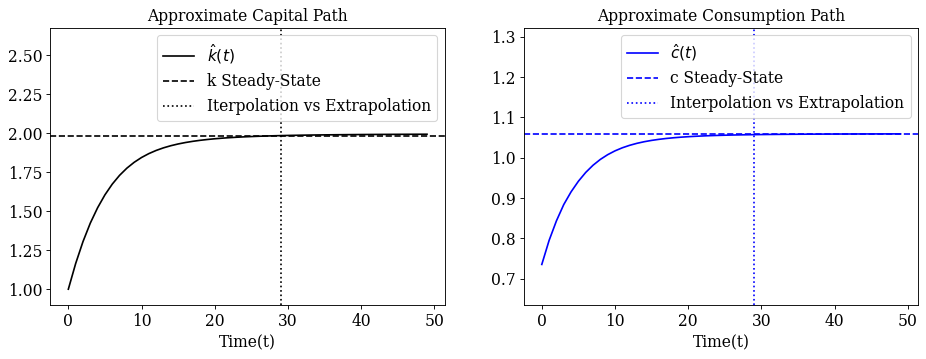

In [17]:
plt.subplot(1, 2 , 1)

plt.plot(time_grid_test,k_hat_path, color='k',  label = r"$\hat{k}(t)$")
plt.axhline(y=k_star, linestyle='--',color='k', label="k Steady-State")
plt.xlabel(r"Time(t)")
plt.axvline(x= train_t_max , color='k', linestyle=':', label = "Iterpolation vs Extrapolation")
plt.title(r"Approximate Capital Path")
plt.ylim([k_0-0.1,k_star*(1+0.35) ])
plt.legend(loc='best')

plt.subplot(1, 2, 2)

plt.plot(time_grid_test,c_hat_path, color='b',  label = r"$\hat{c}(t)$")
plt.axhline(y=c_star, linestyle='--',color='b', label="c Steady-State")
plt.xlabel(r"Time(t)")
plt.axvline(x= train_t_max , color='b', linestyle=':', label = "Interpolation vs Extrapolation")
plt.title(r"Approximate Consumption Path")
plt.ylim([c_hat_path[0]-0.1,c_star*(1+0.25) ])
plt.legend(loc='best')

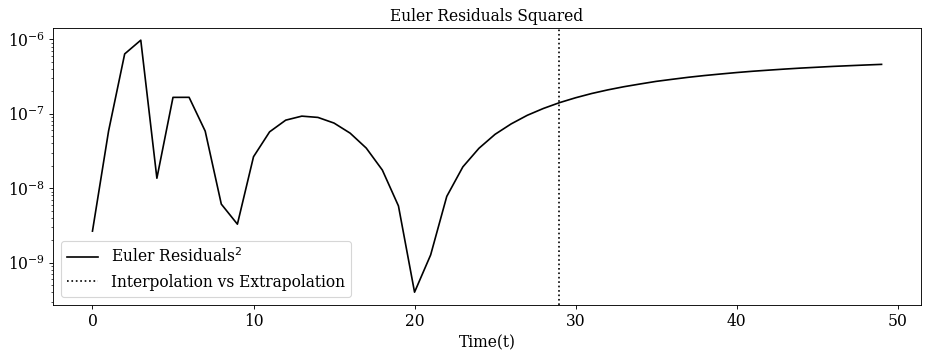

In [18]:
plt.plot(time_grid_test,Euler_res_test**2, color='k',  label = r"Euler Residuals$^2$")
plt.xlabel(r"Time(t)")
plt.axvline(x= train_t_max , color='k', linestyle=':', label = "Interpolation vs Extrapolation")
plt.title(r"Euler Residuals Squared")
plt.legend(loc='lower left')
plt.yscale('log')